In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
import py4DSTEM
from py4DSTEM.process import amorph
from py4DSTEM.process.calibration import ellipse
from py4DSTEM.process.utils.elliptical_coords import *
from scipy.ndimage import affine_transform, binary_closing, gaussian_filter
from scipy.signal import ellip, medfilt2d
from tqdm import tqdm

matplotlib.rcParams["figure.dpi"] = 100


```
The parameters in p are

    p[0] I0          the intensity of the first gaussian function
    p[1] I1          the intensity of the Janus gaussian
    p[2] sigma_ref      std of first gaussian
    p[3] sigma1      inner std of Janus gaussian
    p[4] sigma2      outer std of Janus gaussian
    p[5] c_bkgd      a constant offset
    p[6:8] x0,y0       the origin
    p[8:10] A,B,C       Ax^2 + Bxy + Cy^2 = 1
```


## Test 1

The following code tests to see if the fitting routine works.


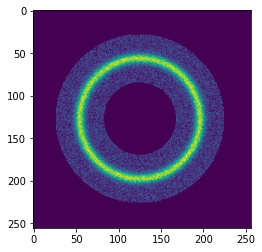

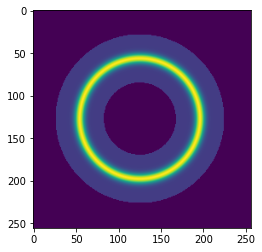

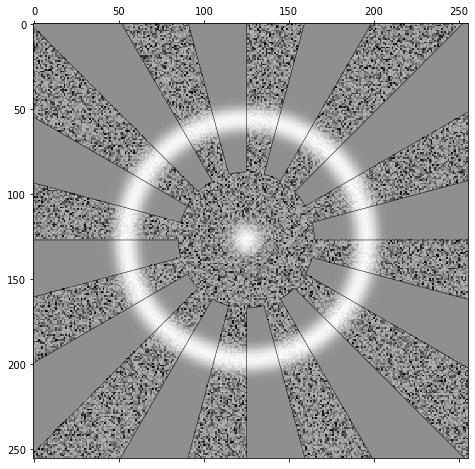

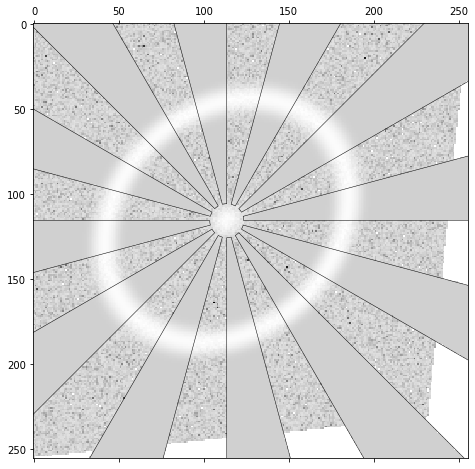

In [2]:
yy, xx = np.meshgrid(np.arange(256), np.arange(256))
coef = [250, 250, 5, 4, 4, 5, 127, 125, 2e-4, -2e-8, 2e-4]
I0, I1, sigma0, sigma1, sigma2, c_bkgd, x0, y0, A, B, C = coef
r2 = A * (xx - x0) ** 2 + B * (xx - x0) * (yy - y0) + C * (yy - y0) ** 2

mask = np.logical_and(r2**0.5 > 0.6, r2**0.5 < 1.4)
# mask = np.ones_like(mask, dtype=bool)

ring = ellipse.double_sided_gaussian(coef, xx, yy) + np.random.rand(256, 256) * 100

coef_fit = [250, 250, 5, 4, 4, 5, 128, 128, 2e-4, 0, 2e-4]
fit = ellipse.fit_ellipse_amorphous_ring(
    ring, (128, 128), (10, 1000), p0=coef_fit, mask=mask
)[1]

plt.figure(1, clear=True)
plt.imshow(ring * mask)

plt.figure(2, clear=True)
ring_fit = ellipse.double_sided_gaussian(fit, xx, yy)
plt.imshow(ring_fit * mask)
py4DSTEM.visualize.vis_special.show_amorphous_ring_fit(
    ring, fitradii=(40, None), p_dsg=fit, maskcenter=False
)

# try on affine transformed data
ring2 = affine_transform(ring, [[1, 0.1], [0.1, 1]])
fit2 = ellipse.fit_ellipse_amorphous_ring(ring2, (110, 110), (10, 200), p0=coef_fit)[1]
py4DSTEM.visualize.vis_special.show_amorphous_ring_fit(
    ring2, p_dsg=fit2, fitradii=(10, None)
)  # TODO remove this


## Test 2

The following code tests strain measurement using a reference ellipse instead of
a circle.

First we make a reference ellipse and a strained ellipse.


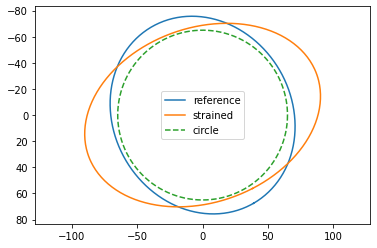

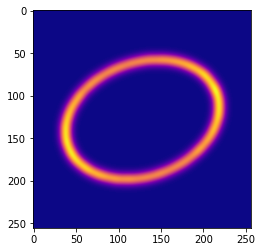

In [3]:
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

yy, xx = np.meshgrid(np.arange(256), np.arange(256))
r = np.sqrt((xx - 128) ** 2 + (yy - 128) ** 2)
r_ref = 65
e11 = 10 / 100
e22 = -20 / 100
e12 = 15 / 100

num_points = 360
ref_x = 1.2
ref_y = 1.05
ref_rot = np.pi / 6
ref_rot_mat = np.asarray(
    [[np.cos(ref_rot), -np.sin(ref_rot)], [np.sin(ref_rot), np.cos(ref_rot)]]
)
t = np.linspace(0, 2 * np.pi, num_points)
x = ref_x * np.cos(t) * r_ref
y = ref_y * np.sin(t) * r_ref

m = np.array([[1 + e11, e12], [e12, 1 + e22]])
m_inv = np.linalg.inv(m)

xy_ref = np.stack((x, y))
xy_ref = np.matmul(ref_rot_mat, xy_ref)  # rotate positions

xy = np.matmul(m_inv, xy_ref)

ring_ref = np.zeros((256, 256))
ring_ref[
    np.round(xy_ref[0, :]).astype(int) + 128,
    np.round(xy_ref[1, :]).astype(int) + 128,
] = 1
ring_ref = gaussian_filter(ring_ref, sigma=5)
ring_ref *= 10000

ring = np.zeros((256, 256))
ring[np.round(xy[0, :]).astype(int) + 128, np.round(xy[1, :]).astype(int) + 128] = 1
ring = gaussian_filter(ring, sigma=5)
ring *= 10000

plt.figure(1, clear=True)
plt.plot(xy_ref[1, :], xy_ref[0, :])
plt.plot(xy[1, :], xy[0, :])
plt.plot(np.cos(t) * r_ref, np.sin(t) * r_ref, "--")
plt.axis("equal")
plt.gca().invert_yaxis()
plt.legend(["reference", "strained", "circle"])

plt.figure(2, clear=True)
plt.imshow(ring, cmap="plasma")


Now we fit the ellipses:


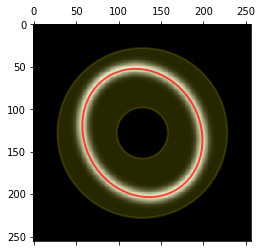

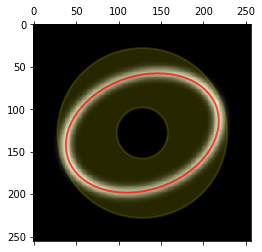

In [4]:
coef_fit = [250, 250, 5, 4, 4, 5, 128, 128, 2e-4, 0, 2e-4]
fit = ellipse.fit_ellipse_amorphous_ring(ring, (128, 128), (10, 1000), p0=coef_fit)
fit_ref = ellipse.fit_ellipse_amorphous_ring(
    ring_ref, (128, 128), (10, 1000), p0=coef_fit
)
py4DSTEM.visualize.show_elliptical_fit(
    ring_ref, (30, 100), fit_ref[0], min=0, max=500, figsize=(4, 4)
)

py4DSTEM.visualize.show_elliptical_fit(
    ring, (30, 100), fit[0], min=0, max=500, figsize=(4, 4)
)


Now we use the A, B, C representation of the ellipse to calculate strains.


In [5]:
A, B, C = fit[1][8], fit[1][9], fit[1][10]
A_ref, B_ref, C_ref = fit_ref[1][8], fit_ref[1][9], fit_ref[1][10]

# now calculate strains

m_ellipse = np.asarray([[A, B / 2], [B / 2, C]])
e_vals, e_vecs = np.linalg.eig(m_ellipse)
ang = np.arctan2(e_vecs[1, 0], e_vecs[0, 0])

rot_matrix = np.asarray([[np.cos(ang), -np.sin(ang)], [np.sin(ang), np.cos(ang)]])

transformation_matrix = np.diag(np.sqrt(e_vals))
transformation_matrix = rot_matrix @ transformation_matrix @ rot_matrix.T

# now fit reference ellipse
m_ellipse_ref = np.asarray([[A_ref, B_ref / 2], [B_ref / 2, C_ref]])
e_vals_ref, e_vecs_ref = np.linalg.eig(m_ellipse_ref)
ang_ref = np.arctan2(e_vecs_ref[1, 0], e_vecs_ref[0, 0])

rot_matrix_ref = np.asarray(
    [[np.cos(ang_ref), -np.sin(ang_ref)], [np.sin(ang_ref), np.cos(ang_ref)]]
)

transformation_matrix_ref = np.diag(np.sqrt(e_vals_ref))
transformation_matrix_ref = (
    rot_matrix_ref @ transformation_matrix_ref @ rot_matrix_ref.T
)

# uncomment to confirm that we used to assume circle - the two printed results should match
# transformation_matrix_ref = np.asarray([[1,0],[0,1]])

# print(f"angle0 = {ang_ref:.4f}")
print(
    f"This is the transformation from a circle to the reference ellipse\ntransformation_matrix_ref=\n{transformation_matrix_ref}\n"
)
# print(f"angle = {ang:.4f}")
print(
    f"This is the transformation from a circle to the fitted (strained) ellipse\ntransformation_matrix=\n{transformation_matrix}\n"
)

# now compute strains
e11_fit = transformation_matrix[0, 0] - 1
e22_fit = transformation_matrix[1, 1] - 1
e12_fit = 0.5 * (transformation_matrix[0, 1] + transformation_matrix[1, 0])

# If you have a transformation matrix from A->B and from A->C, this is how
# you get the transformation matrix from B->C. A->B represents circle to
# reference ellipse, A->C is circle to strained ellipse, and so then B->C
# is reference ellipse to strained ellipse, from which we can then extract
# strains.
transformation_matrix_from_ref = transformation_matrix @ np.linalg.inv(
    transformation_matrix_ref
)
e11_fit_from_ref = transformation_matrix_from_ref[0, 0] - 1
e22_fit_from_ref = transformation_matrix_from_ref[1, 1] - 1
e12_fit_from_ref = 0.5 * (
    transformation_matrix_from_ref[0, 1] + transformation_matrix_from_ref[1, 0]
)

print(
    "\nThe fit will not be exact as we are fitting the image, not points.\nStrain with respect to perfect circle:"
)
print(f"e11 = {e11:.3f}, e11_fit = {e11_fit:.3f}")
print(f"e22 = {e22:.3f}, e22_fit = {e22_fit:.3f}")
print(f"e12 = {e12:.3f}, e12_fit = {e12_fit:.3f}\n")
print("Strain with respect to reference ellipse:")
print(f"e11 = {e11:.3f}, e11_fit_from_ref = {e11_fit_from_ref:.3f}")
print(f"e22 = {e22:.3f}, e22_fit_from_ref = {e22_fit_from_ref:.3f}")
print(f"e12 = {e12:.3f}, e12_fit_from_ref = {e12_fit_from_ref:.3f}")
print("These values should be roughly equivalent. ")


This is the transformation from a circle to the reference ellipse
transformation_matrix_ref=
[[ 0.01330984 -0.00079107]
 [-0.00079107  0.01421748]]

This is the transformation from a circle to the fitted (strained) ellipse
transformation_matrix=
[[0.01448748 0.00130358]
 [0.00130358 0.01127232]]


The fit will not be exact as we are fitting the image, not points.
Strain with respect to perfect circle:
e11 = 0.100, e11_fit = -0.986
e22 = -0.200, e22_fit = -0.989
e12 = 0.150, e12_fit = 0.001

Strain with respect to reference ellipse:
e11 = 0.100, e11_fit_from_ref = 0.098
e22 = -0.200, e22_fit_from_ref = -0.199
e12 = 0.150, e12_fit_from_ref = 0.149
These values should be roughly equivalent. 


## Data analysis

Now knowing that the code works, we can move forward with analyzing our data.


In [6]:
data = py4DSTEM.io.read(
    "/Volumes/tom_home/Documents/Research/Data/2020/amorphous_py4DSTEM_paper/binned_data.h5",
    mem="MEMMAP",
    data_id=0,
)

# bragg peaks from crystalline region
peaks = py4DSTEM.io.read(
    "/Volumes/tom_home/Documents/Research/Data/2020/amorphous_py4DSTEM_paper/Dataset38_20190918_processing.h5",
    data_id="braggpeaks_unshifted",
)

# mask computed below (mask_r is defined later in the code... move to here)
# that masks off both bragg peaks as well as the central spot.
mask_array = py4DSTEM.io.read(
    "/Volumes/tom_home/Documents/Research/Data/2020/amorphous_py4DSTEM_paper/data_mask_spots_and_radius.h5",
    data_id=0,
    mem="MEMMAP",
)
# mask_array = amorph.make_mask_array(peaks, data.data.shape, peak_radius=4.3, bin_factor=4, universal_mask=mask_r)


Reading PointListArray: 100%|██████████| 46170/46170 [00:32<00:00, 1407.33PointList/s]


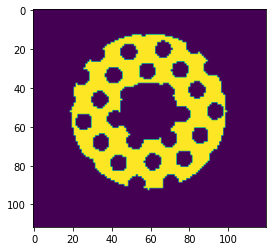

In [7]:
# this shows what the mask_mask array looks like in a crystalline region.
plt.imshow(mask_array.data[15, 24, ...])


Plot some mean images, to see the data we're working with

100%|██████████| 46170/46170 [00:52<00:00, 874.92it/s]


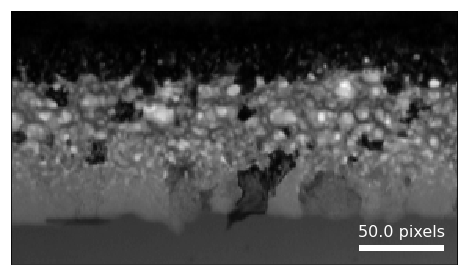

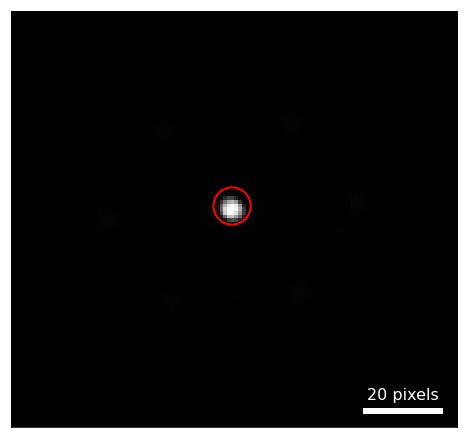

In [8]:
mean_dp = data.get_dp_mean()
center = (52, 59)
R = 5
mean_bf = data.get_virtual_image(mode='circle', geometry=(center, R))
py4DSTEM.show(mean_bf)
py4DSTEM.show(mean_dp, circle={'center':center, 'R': R})

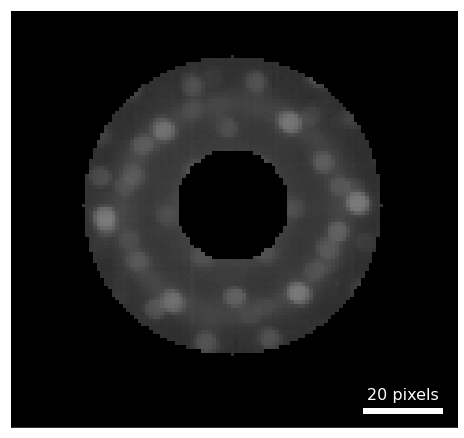

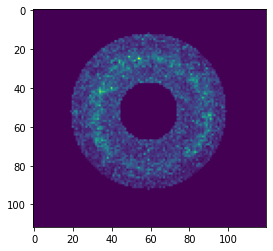

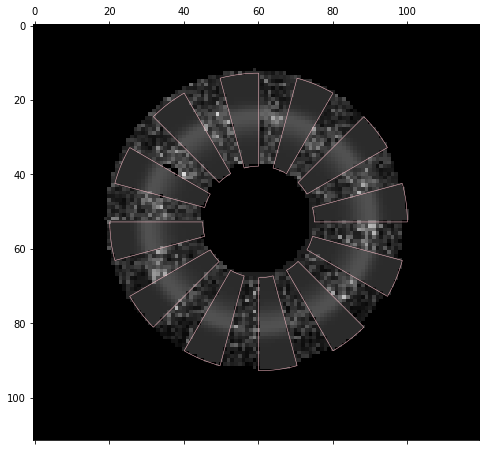

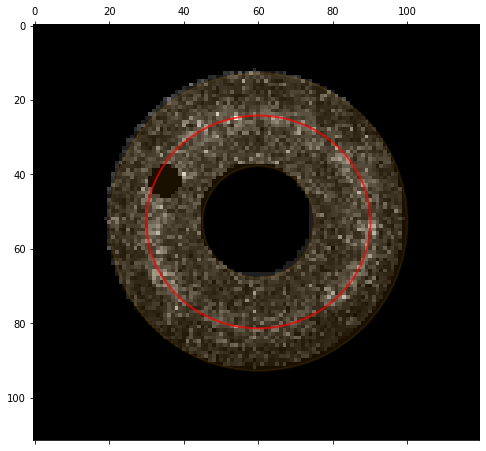

In [9]:
# make a mask of region to fit

yy, xx = np.meshgrid(np.arange(mean_dp.shape[1]), np.arange(mean_dp.shape[0]))
r = ((xx - center[0]) ** 2 + (yy - center[1]) ** 2) ** 0.5
mask_r = np.ones_like(r)
ri, ro = 15, 40
mask_r[r < ri] = 0
mask_r[r > ro] = 0
mask_r = mask_r.astype(bool)

py4DSTEM.show(mean_dp, mask=mask_r, scaling="log")
# plt.imshow(mask_r.data)

i, j = 138, 50
test_im = data.data[i, j, :, :]

# test_im = np.mean(data.data[-10:-1, -10:-1,:,:], axis=(0,1))
plt.figure(10, clear=True)
# test_im = np.log(test_im + 0.01)
plt.imshow(test_im * mask_r)

p_init = [2.95e5, 7e2, 1.5, 2.1, 2.2, 200, 51, 56, 0.001, 0, 0.001]
# test_fit = ellipse.fit_ellipse_amorphous_ring(test_im, 50,60,10,40,p0=p_init,)[1]
test_fit = ellipse.fit_ellipse_amorphous_ring(
    test_im, p_init[6:8], (10, 400), p0=p_init, mask=mask_array[i, j, ...]
)
# compare_double_sided_gaussian(test_im, p_init, mask=mask_r)
py4DSTEM.visualize.vis_special.show_amorphous_ring_fit(
    test_im,
    p_dsg=test_fit[1],
    fitradii=(ri, ro),
    scaling="none",
    fitbordercolor="pink",
    cmap=("gray", "gray"),
    maskcenter=True,
    mask=mask_array[i, j, ...],
)

py4DSTEM.visualize.vis_special.show_elliptical_fit(
    test_im,
    fitradii=(ri, ro),
    p_ellipse=test_fit[0],
    alpha_ann=0.1,
    color_ann="orange",
    mask=mask_array[i, j, ...],
)


Fit all ellipses

**Note, the following step will take ~2 hours on a Mac M1 Air**


In [10]:
# uncomment this to fit stack
# coef_array = amorph.fit_stack(data, p_init, ri, ro, mask_array.data)
# save the array after fitting all ellipses.
# np.save("coef_array.npy", coef_array)

# uncomment this to use prefit stack.
coef_array = np.load('coef_array.npy', 'r')

Test a couple patterns to make sure the fit works.


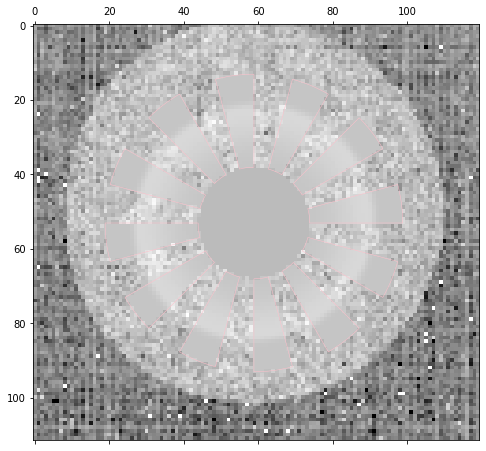

In [11]:
i, j = 134, 59
py4DSTEM.visualize.vis_special.show_amorphous_ring_fit(
    data.data[i, j, ...],
    p_dsg=coef_array[i, j, ...],
    fitradii=(ri, ro),
    scaling="log",
    fitbordercolor="pink",
    cmap=("gray", "gray"),
    maskcenter=True,
)


Compute strain and plot strains. Kernel size is for the local smoothing.


reference (A, B, C) = [0.0011929797378475888, 3.90293015052263e-05, 0.0011032331983730835]
median strains [exx, eyy, exy] = [-2.07940074e-05 -2.92856121e-05  3.65801769e-05]


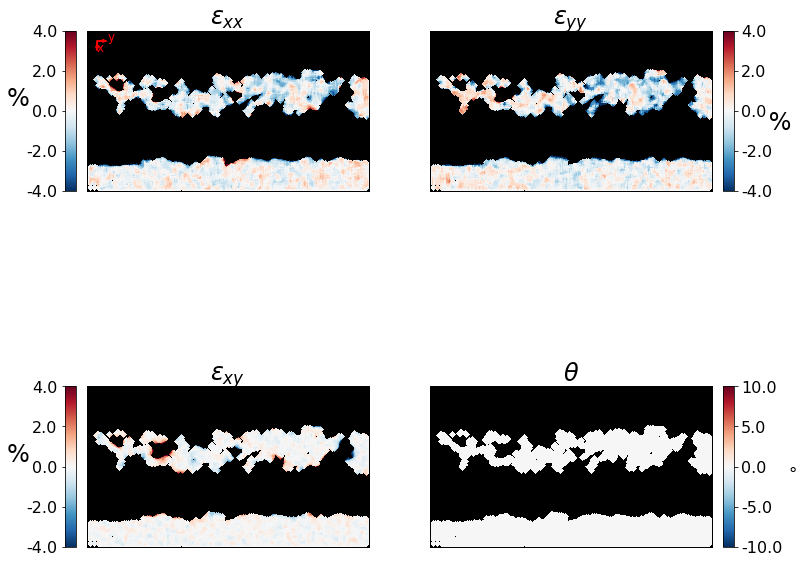

In [12]:
from py4DSTEM.io.datastructure import RealSlice

kernel_size = 5
amorphous_row = 135
radius_ref = list(np.median(coef_array[135:, :, 8:11], axis=(0, 1)))

strains = amorph.calculate_coef_strain(coef_array, r_ref=radius_ref)
print(f"reference (A, B, C) = {radius_ref}")
print(
    f"median strains [exx, eyy, exy] = {np.median(np.asarray(strains)[:,amorphous_row:,:], axis=(1,2))}"
)

mask_strain = np.logical_or(np.abs(strains[0]) > 0.1, np.abs(strains[1]) > 0.1)
mask_strain = binary_closing(mask_strain, iterations=3, border_value=1)

normalized_strains = [
    medfilt2d(i, kernel_size=kernel_size)
    - np.median(medfilt2d(i, kernel_size=kernel_size)[amorphous_row:, :])
    for i in strains
]


im_size = data.shape[0:2]

strain_map = RealSlice(
    data=np.zeros((im_size[0], im_size[1], 5)),
    slicelabels=("e_xx", "e_yy", "e_xy", "theta", "mask"),
    name="strain_map",
)

strain_map.get_slice("mask").data[:] = ~mask_strain

strain_map.get_slice("e_xx").data[:] = normalized_strains[0]
strain_map.get_slice("e_yy").data[:] = normalized_strains[1]
strain_map.get_slice("e_xy").data[:] = normalized_strains[2]

py4DSTEM.visualize.show_strain(strain_map, vrange_exx=[-4, 4], vrange_theta=[-10, 10], axes_x0=10, axes_y0=10)